<figure>
  <IMG SRC="LogoENSEGID.png" WIDTH=125 ALIGN="right">
</figure>

# EXPLOITATION D'UN MODELE NUMERIQUE DE TERRAIN (MNT) EN HYDROLOGIE

# Comment profiter de Python quand on est (presque) nul en programmation ! Mais qu'on a (un peu) de suite dans les idées (et Internet)

## Objectif général

Afin d'étudier les caractéristiques du réseau hydrographique associé à un exutoire, nous allons utiliser un Modèle Numérique de Terrain (MNT), qui est une représentation numérique matricielle de la topographie (cf.: https://learn.arcgis.com/fr/related-concepts/digital-elevation-models.htm).
La représentation de la topographie se fait sous forme d'une matrice, dont chaque cellule correspond à une superficie unitaire fonction de sa taille (du pas de discrétisation) et au sein de laquelle l'altitude a été moyennée.
    
<figure>
  <IMG SRC="dem_principe.png" WIDTH=350 ALIGN="center">
</figure>

Plusieurs outils permettant de traiter ce type de données existent, essentiellement des SIG (dont l'excellent et gratuit QGIS (https://www.qgis.org). Toutefois il est également possible d'utiliser d'autres types de ressources comme le langage de programmation Python. Largement développé, Open source, il dispose de nombreuses librairies permettant de traiter un grand nombre de problèmes d'ingénierie dans une multitude de domaines, dont les géosciences.
    
La première étape est de disposer d'une distribution Python. C'est gratuit et très documenté sur le net, donc on ne détaillera pas ici la procédure d'installation. La solution retenue ici est l'outil JupyterLab (https://jupyter.org/), sous distribution Anaconda ( https://www.anaconda.com ). Encore une fois, internet sera votre meilleur allié si vous voulez installer cet outil. L'avantage de cette interface est de pouvoir être également accessible en ligne via une machine virtuelle, sans avoir à installer quoique ce soit, si le créateur du programme a bien voulu se donner la peine de le mettre à disposition !
    
L'esprit général de ce tutorial est de répondre à une problématique précise, avec un minimum de connaissance en programmation, et un maximum de réflexion à partir de ressources existantes (qu'on n'oubliera pas bien sûr de citer ! C'est la règle du jeu !). La procédure générale suivie dans cet exercice est construite à partir des tutoriaux développés pour la bibliothèque Pyshed (https://github.com/mdbartos/pysheds). Qu'il soit ici grandement remercié!
 
    
Pour notre problématique, on dispose d'un modèle numérique de terrain au pas de 30 mètres, issu du serveur de la NASA/USGS (gdex.cr.usgs.gov). L'exutoire du bassin versant à considérer est situé aux coordonnées WGS84 (27°50'05.0"N 107°54'59.9"W) (les plus curieux pourront allez se promener sur la toile pour voir à quoi ressemble le paysage!).

Une représentation de la zone d'étude élargie est donnée ci-dessous (source Google Map):
<figure>
  <IMG SRC="mnt_localisation.png" WIDTH=600 ALIGN="center">
</figure>

Et avec un zoom précis sur la zone d'étude:
<figure>
  <IMG SRC="Topo_DEM.png" WIDTH=600 ALIGN="center">
</figure>



## Préalable

Pour toute application développée en Python, on commence par charger les bibliothèques optionnelles qui sont nécessaires à l'élaboration du programme. Généralement, on en rajoute au fur et à mesure du développement du projet. Outre les bibliothèques classiques (os, numpy, matplotlib,...), on récupère des bibliothèques plus spécifiques à notre problème:
- Pyshed: https://pypi.org/project/pysheds/

In [1]:
#Import des librairies requises
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors

#traitement du MNT
from pysheds.grid import Grid
#creation des shapefiles
from shapely import geometry, ops
import fiona
import warnings

import warnings
warnings.filterwarnings('ignore')


# Exploitation standard du MNT

## Récupération du MNT

Il existe plusieurs manière de récupérer les données d'un modèle numérique de terrain. Dans le cadre de l'exercice, on utilisera la lecture directe d'un fichier 'name.TIF', correspondant au format standard d'échange pour un MNT, récupéré par ailleurs et déjà présent dans le répertoire de travail. En fin d'activité, une procédure de récupération à partir d'un fournisseur gratuit est également présentée, permettant d'obtenir gratuitement un MNT de résolution 30 mètre à partir des données de SRTM de la NASA (ce qui est quand même classe), sur une zone quelconque.

Il est utile de connaître les informations natives du MNT:
- système de coordonnées
- extension (coordonnées associées au système natif
- identification des données aberrantes
- taille (ligne, colonnes);
- Altitude maximale et localisation (L,C);
- Altitude minimale et localisation (L,C);

Ces informations permettent de jongler entre les différents types de coordonnées, à savoir les coordonnées géographiques natives du MNT (WGS 84) et le repère cartésien indexé en (nombre de ligne x nombre de colonne) sur cette emprise. Il est largement conseillé de se fire un petit schéma pour ce repérer dans tout ces systèmes:

<figure>
  <IMG SRC="mnt_coord.png" WIDTH=600 ALIGN="center">
</figure>


In [2]:
#Lecture du fichier .TIF
grid = Grid.from_raster('DEM_demo.tif', data_name='dem')

#Suppression des données formant le cadre du MNT (on évite les effets de bords courants sur les MNT)
elevDem=grid.dem[:-1,:-1]

print('Système de coordonnées du MNT:', grid.crs.srs)
print('Zone emprise du MNT:', grid.bbox)
print('Données manquantes identifiées par:', grid.nodata)
print("Taille du MNT (n Lignes,m Colonnes)", grid.shape)
print("Altitude maximale",np.max(grid), "rencontrée aux indices (L,C) suivants", np.where(grid == np.max(grid)))
print("Altitude minimale",np.min(grid), "rencontrée aux indices (L,C) suivants", np.where(grid == np.min(grid)))

# localisation de l'exutoire par ses coordonnées
x_exu, y_exu = -107.91663,27.83479
#identification de la cellule comprenant l'exutoire dans la grille
col_ex, row_ex = grid.nearest_cell(x_exu, y_exu)
print("Numéro de colonne incluant l'exutoire",col_ex)
print("Numéro de ligne incluant l'exutoire",row_ex)

Système de coordonnées du MNT: +proj=longlat +datum=WGS84 +no_defs
Zone emprise du MNT: (-107.99263888888889, 27.764583333334276, -107.78069444444428, 27.97902777777889)
Données manquantes identifiées par: -32768
Taille du MNT (n Lignes,m Colonnes) (771, 762)
Altitude maximale <pysheds.grid.Grid object at 0x7fb81521b6a0> rencontrée aux indices (L,C) suivants (array([0]),)
Altitude minimale <pysheds.grid.Grid object at 0x7fb81521b6a0> rencontrée aux indices (L,C) suivants (array([0]),)
Numéro de colonne incluant l'exutoire 274
Numéro de ligne incluant l'exutoire 519


## Représentation 2D "image" en repère matriciel (index ligne / index colonne)

Ce mode de représentation peut être plus pratique pour se repérer dans la matrice, à condition de ne pas oublier que la matrice commence à l'index (0,0) !

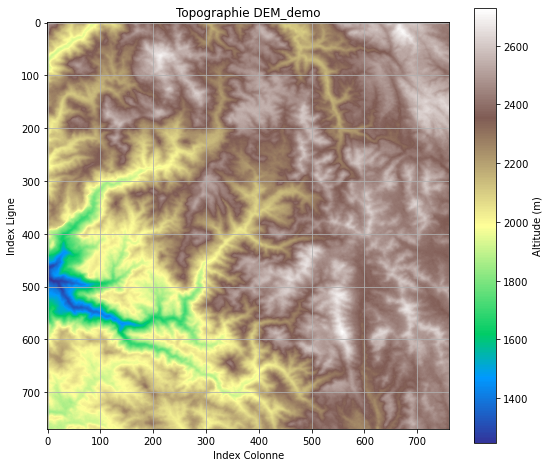

In [3]:
## Représentation 2D "image" en repère matriciel (index ligne / index colonne)

plt.figure(figsize=(9,8))
plt.imshow(elevDem, cmap="terrain")
plt.title("Topographie DEM_demo")
plt.xlabel('Index Colonne')
plt.ylabel('Index Ligne')
plt.colorbar(label="Altitude (m)")
plt.grid()
plt.show()

## Représentation 2D "image" en coordonnées WGS84 (coordonnées natives du MNT)

Cette présentation produit une image "propre", prête à être intégrée dans un rapport.

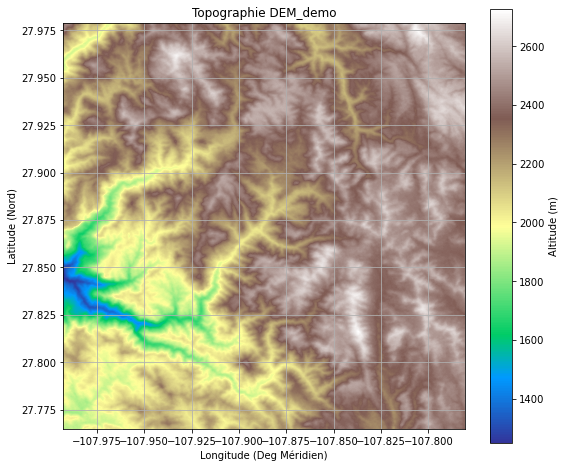

In [4]:
## Représentation 2D "image" en coordonnées WGS84 (coordonnées natives du MNT)

plt.figure(figsize=(9,8))
plt.imshow(elevDem, extent=grid.extent,cmap="terrain")
plt.title("Topographie DEM_demo")
plt.xlabel('Longitude (Deg Méridien)')
plt.ylabel('Latitude (Nord)')
plt.colorbar(label="Altitude (m)")
plt.grid()

#si vous voulez récuperer une image du MNT
#plt.savefig('Topo_DEM.png')

## Présentation alternative: les courbes d'altitude

Cette représentation est plus familière pour els utilisateurs de cartes topographiques "papier" mais d'un point de vue esthétique, ce n'est pas vraiment le meilleur rendu. 

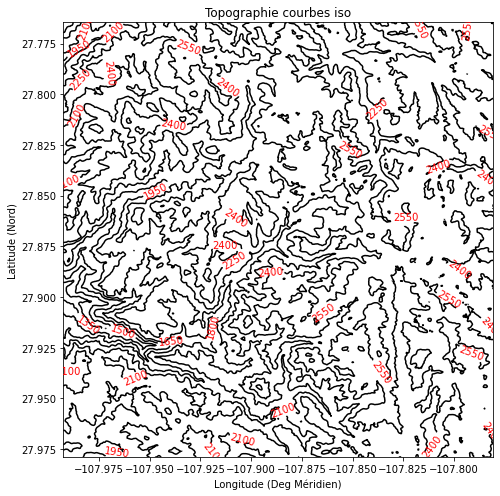

In [5]:
## Présentation alternative: les courbes d'altitude

plt.figure(figsize=(9,8))
ax = plt.contour(elevDem,extent=grid.extent, colors = "black", 
            levels = list(range(0, 2800, 150)))
plt.title("Topographie courbes iso")
plt.xlabel('Longitude (Deg Méridien)')
plt.ylabel('Latitude (Nord)')
plt.gca().set_aspect('equal', adjustable='box')
#attention pour etre homogene avec les autres representations li faut inverser l'axe des ordonnees
plt.gca().invert_yaxis()
plt.clabel(ax,colors = 'red', fmt= '%.0f', inline = True)
plt.show()

## Tracés de coupes topographiques

A partir du MNT, on peut tracer directement des coupes topographiques selon l'axe des abscisses (Est-Ouest) ou l'axe des ordonnées (Nord-Sud). Les tracés selon d'autres directions sont plus complexes et restent d'in rapport investissement/bénéfices assez limité.

Cet exercice nécessite d'identifier dans la matrice du MNT la ligne ou la colonne correspondant à la coupe à réaliser. Par exemple, pour réaliser une coupe WE ou NS passant par les altitudes extrêmes

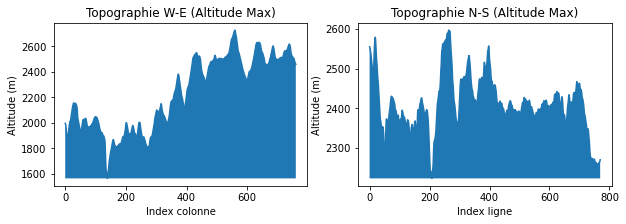

In [6]:
## Tracés de coupes topographiques passant par l'altitude maximale rencontrée sur le MNT

ztop = (np.where(elevDem == np.max(elevDem)))[0]

crossEW=elevDem[ztop[0],:]
xcross = np.arange(elevDem.shape[1])
crossNS=elevDem[:,ztop[1]]
ycross = np.arange(elevDem.shape[0])

plt.figure(figsize = (10, 3))
plt.subplot(1, 2, 1)
plt.plot(crossEW)
plt.fill_between(xcross, crossEW, np.min(crossEW))
plt.title("Topographie W-E (Altitude Max)")
plt.xlabel('Index colonne')
plt.ylabel('Altitude (m)')
plt.subplot(1, 2, 2)
plt.plot(crossNS)
plt.fill_between(ycross, crossNS, np.min(crossNS))
plt.title("Topographie N-S (Altitude Max)")
plt.xlabel('Index ligne')
plt.ylabel('Altitude (m)')
plt.show()

# Analyse du réseau hydrographique

## Traitement préalable du MNT - Préconditionnement

Le MNT n'est pas exempt d'artéfacts liés au mode d'acquisition et/ou au mode de traitement des données brutes permettant sa création. Ces artefacts peuvent créer des problèmes pour certaines applications notamment pour l'analyse hydrologique.
L'existence de zones de dépression ponctuelle peut générer des erreurs lorsqu'on cherche à déterminer le réseau d'écoulement sur un MNT, en limitant la continuité hydraulique. Un des pré-traitements consiste à lisser le MNT en "remplissant" ces petites dépressions, comme schématisé ci-dessous:
    
<figure>
  <IMG SRC="sink.png" WIDTH=250 ALIGN="center">
</figure>

La deuxième étape consiste à résoudre les ambiguités d'écoulement qui peuvent être crées par ce remplissage "fictif", en reliant les pentes autour des zones comblées.

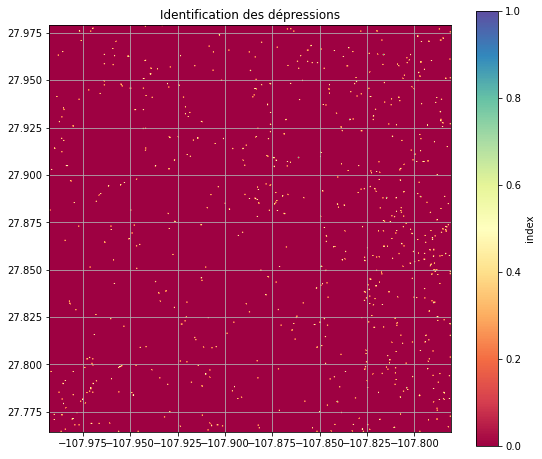

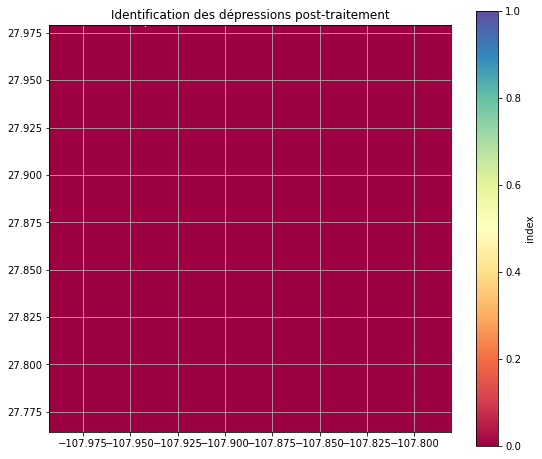

In [7]:
# Identification des depressions

depressions = grid.detect_depressions('dem')

# Remplissage des depressions
grid.fill_depressions(data='dem', out_name='flooded_dem')

# Plot depressions avant remplissage
plt.figure(figsize=(9,8))
plt.imshow(depressions, extent=grid.extent,cmap='Spectral')
plt.colorbar(label='index')
plt.grid()
plt.title("Identification des dépressions")
plt.show()

# Plot depressions post remplissage
plt.figure(figsize=(9,8))
plt.imshow(grid.detect_depressions('flooded_dem'), extent=grid.extent,cmap='Spectral')
plt.colorbar(label='index')
plt.grid()
plt.title("Identification des dépressions post-traitement")
plt.show()



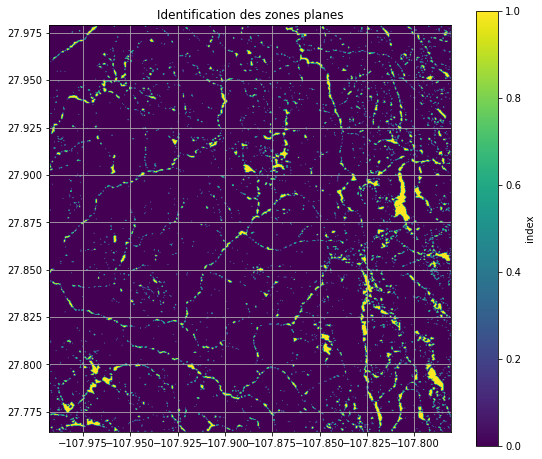

In [8]:
# Detecter les zones lpanes ('flats')

flats = grid.detect_flats('flooded_dem')

# Plot flats
plt.figure(figsize=(9,8))
plt.imshow(flats, extent=grid.extent)
plt.colorbar(label='index')
plt.title("Identification des zones planes")
plt.grid()

### Reconstruction du MNT post-conditionné

Cette étape permet de lever les ambiguités sur les zones planes qui seraient susceptibles de créer une rupture dans la continuité de l'écoulemment.

In [ ]:
grid.resolve_flats(data='flooded_dem', out_name='inflated_dem')

plt.figure(figsize=(9,8))
plt.imshow(grid.inflated_dem[:-1,:-1], extent=grid.extent,cmap="terrain")
plt.colorbar(label='Altitude (m)')
plt.title("MNT post-conditionné")

plt.grid()

### Différence entre MNT initial et MNT reconditionné

In [ ]:
ecart=grid.inflated_dem-grid.dem

plt.figure(figsize=(9,8))
plt.imshow(ecart, extent=grid.extent,cmap="tab10")
plt.colorbar(label='Différence entre MNT (m)')
plt.grid()



# Exploitation thématique en hydrologie: identifier un bassin versant associé à un exutoire et son réseau d'écoulement

## Procédure générale

Les applications hydrologiques sont basées sur l'identification des directions d'écoulement au sein du MNT. Cette phase nécessite la création d'une carte des écoulements "primaires", c'est à dire de cellule à cellule en fonction de la topologie locale. Les directions d'écoulement sont codées en fonction d'un modèle directionnel. Le modèle à 8 directions (D8) est devenu un standard (figure ci-dessous). Les directions sont codées selon la convention (b). A partir de ce masque appliqué au MNT (a), la matrice des écoulements (c) est obtenue;correspondant au réseau (d):
    
<figure>
  <IMG SRC="d8b.png" WIDTH=300 ALIGN="center">
</figure>

Le réseau d'écoulement principal est dérivé du réseau élémentaire en calculant des indices d'accumulation et en ne retenant que le réseau au delà d'un indice d'accumulation seuil (figure ci-après - Gunawan et al., 2011). L'indice d'accumulation pour une cellule corresponds au nombre de cellule drainées par la cellule en question.
    
<figure>
  <IMG SRC="acc.png" WIDTH=600 ALIGN="center">
</figure>
    
Déterminer un bassin versant et le réseau d'écoulement associé à un exutoire donné nécessite donc plusieurs étapes:
    
- création de la carte directionnelle d'écoulement
- détermination du bassin versant associé à l'exutoire
- détermination des indices d'accumulation au sein du bassin versant
- calcul du réseau hydrographique au seuil de drainage considéré


## Création de la carte directionnelle d'écoulement

Cette phase nécessite la création d'un "masque" de direction en fonction du choix de convention (dans notre cas, la convention est D8). A partir de ce masque, les directions d'écoulement pour chaque pixel sont calculées.

In [ ]:
# Creation du masque de direction D8
#N    NE    E    SE    S    SW    W    NW
dirmap = (64,  128,  1,   2,    4,   8,    16,  32)

# Calcul des directions d'écoulement D8
# -------------------------------------
grid.flowdir(data='inflated_dem', out_name='dir', dirmap=dirmap)
grid_dir=grid.view('dir')

# Creation de la carte d'ecoulement avec une legende correspondant aux direction D8
cmap = mpl.colors.ListedColormap(['blue','black','red','yellow','tan','teal','blueviolet','aqua'])
bounds=[1,1.8,2.2,4.4,8.8,16.4,32.5,64.5,129]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

plt.figure(figsize=(9,8))
plt.imshow(grid_dir, extent=grid.extent,cmap = cmap,norm=norm)
plt.grid()
plt.colorbar(boundaries=bounds,ticks=[1,2,4,8,16,32,64,128],label='Direction écoulement D8')
plt.show()


## Détermination du bassin versant associé à l'exutoire

Un petit rappel sur la définition de notre bassin versant: un bassin versant est une surface ascendante d’où s’écoule un flux vers un orifice de drainage commun. Il peut appartenir à un bassin versant de plus grande taille. Il peut également englober des bassins plus petits, appelés sous-bassins. Les limites entre bassins versants sont appelées des lignes de crêtes. Un point d'écoulement correspond au point au niveau duquel l'eau sort d'une surface. Ce point est le plus bas sur la limite du bassin versant.
La définition du bassin versant dépends donc du choix du de l'exutoire et d'un indice d'échelle associé.

L'exutoire d'intérêt a les coordonnées WGS84(-107.91663,27.83479).

A partir de ce point, on identifie le bassin versant à partir de la grille de direction.


In [ ]:
# localisation de l'exutoire par ses coordonnées
x_exu, y_exu = -107.91663,27.83479

# détermination du bassin versant
grid.catchment(data='dir', x=x_exu, y=y_exu, dirmap=dirmap, out_name='catch',
               recursionlimit=15000, xytype='label', nodata_out=0)

# Recadrage de la zone d'affichage au BV delimité
grid.clip_to('catch')

# création d'une variable BV à utiliser pour les vues
BV = grid.view('dem', nodata=np.nan)

plt.figure(figsize=(9,8))
plt.imshow(BV, extent=grid.extent,cmap="terrain")
plt.colorbar(label='Altitude (m)')
plt.grid()

#si on veut exporter le resultat dans un nouveau fichier MNT raster
#grid.to_raster(BV, 'clippedElevations_WGS84.tif')

## Détermination des indices d'accumulation au sein du bassin versant

L'indice d'accumulation est déterminé de proche en proche à partir de la carte directionnelle en s'incrémentant de cellule en cellule dans le sens de l'écoulement, c'est à dire dans le sens des altitudes décroissantes.

In [ ]:
# Calcul des indices d'accumulation

grid.accumulation(data='catch', dirmap=dirmap, pad_inplace=False, out_name='acc')

accView = grid.view('acc', nodata=np.nan)
plt.figure(figsize=(9,8))
plt.imshow(accView, extent=grid.extent, cmap='Spectral')
plt.colorbar(label='Index accumulation')
plt.grid()            
           

## Calcul du réseau hydrographique au seuil de drainage considéré

A partir de la carte des indices, on choisit un seuil au delà duquel le réseau hydrographique ne sera plus considéré comme actif. Il n'y a pas de règle absolue pour le choix de la valeur de l'indice. Chaque cas doit être analysé et la méthode essais/erreurs reste la plus pratique pour aboutir à la restitution correspondant à la problématique à traiter.

Ci-dessous, plusieurs valeurs de seuil sont proposées afin de mettre en évidence l'influence de ce paramètre sur la densité du réseau hydrographique isolé.

In [ ]:

#variable en fonction de l'indice - seuiller le découpage du réseau hydro
branche10 = grid.extract_river_network(fdir='catch', acc='acc',
                                      threshold=10, dirmap=dirmap)
branche50 = grid.extract_river_network(fdir='catch', acc='acc',
                                      threshold=50, dirmap=dirmap)
branche500 = grid.extract_river_network(fdir='catch', acc='acc',
                                      threshold=500, dirmap=dirmap)
branche5000 = grid.extract_river_network(fdir='catch', acc='acc',
                                      threshold=5000, dirmap=dirmap)

#representation graphique du reseau hydro (variable/titre à modifier selon le seuil voulu)
plt.figure(figsize=(9,8))
plt.imshow(BV, extent=grid.extent,cmap="binary")
plt.title("Réseau hydrographique - Seuil = 500")
plt.grid()            
for branch in branche500['features']:
     line = np.asarray(branch['geometry']['coordinates'])
     plt.plot(line[:, 0], line[:, 1])

streams = grid.extract_river_network('catch', 'acc', threshold=10, dirmap=dirmap)


## Calcul de la distance d'écoulement à l'exutoire

Cet attribut est directement lié au réseau hydrographique isolé. Il permet de cartographier la distance que l'eau doit parcourir pour parvenir à l'exutoire. L'unité de mesure est la taille de cellule. C'est à dire que la distance est comptée en nombre de cellule.

Exemple :
- cellule de taille $\Delta = 100$ mètres
- nombre de cellules entre l'exutoire et un point du BV: $n=430$
- distance "réelle" L parcourue par l'eau: $L = {n}{\Delta} = 430 \times 100 = 43000$ mètres


In [ ]:
# Calcul de la distance pour chaque cellule à l'exutoire (unite = cellule soit 30 m x 30 m)
# -------------------------------------------
grid.flow_distance(data='catch', x=x_exu, y=y_exu, dirmap=dirmap,
                   out_name='dist', xytype='label')
distance=grid.view('dist')

plt.figure(figsize=(9,8))
plt.imshow(distance, cmap='Spectral')
plt.colorbar(label="distance à l'exutoire (unite = cellule soit 30 m)")
plt.title("Réseau hydrographique - Seuil = 500")
plt.grid()            


## Export des résultats au format SIG

Même si les cartes produites nativement durant cet exercice sont intégrables directement dans un document, vous pouvez avoir besoin de récupérer certains éléments pour les combiner avec d'autres données géoréférencées. C'est possible à l'aide d'un logiciel de SIG (par exemple QGIS).

Les SIG utilisents 2 types de données: les données RASTER (type MNT) qui sont des données matricielles et les données vecteurs qui correspondent à un codage spatial d'un objet ou d'un groupe d'objet sous la forme de couples de coordonnées et éventuellement de l'information qualitative (X,Y,info). Les données vectorielles sont classiquement stockées dans des fichiers *shapefile* ".shp".


### Création de l'objet vectoriel bassin versant

In [ ]:
# Tracé du BV pour l'exutoire (cela a déjà été fait, mais bon...)
grid.catchment(data='dir', x=x_exu, y=y_exu, dirmap=dirmap, out_name='catch',
               recursionlimit=15000, xytype='label', nodata_out=0)

# Ajustement de la fenêtre au BV
grid.clip_to('catch')

#Création de l'objet vectoriel qui va être ensuite exporté
shapes = grid.polygonize()

#pour info, on peut représenter l'objet vectoriel
#on remarque qu'il faut boucler sur toutes les coordonnées qui composent l'objet jectoriel
fig, ax = plt.subplots(figsize=(6.5, 6.5))

for shape in shapes:
    coords = np.asarray(shape[0]['coordinates'][0])
    ax.plot(coords[:,0], coords[:,1], color='cyan')
    
ax.set_xlim(grid.bbox[0], grid.bbox[2])
ax.set_ylim(grid.bbox[1], grid.bbox[3])
ax.set_title('Limites du BV (vecteur)')

### Ecriture du fichier du bassin versant (*.shapefile)

Les procédures d'écriture de fichier en Python (et plus généralement dans les langages de progrmmation) sont assez complexes pour les non spécialistes. Il faut donc s'appuyer sur les exemples disponibles dans les différents tutoriaux et pages disponibles sur le net.

On y arrive ... avec un peu de persévérance !

Le fichier s'appellera BV.shp
(en fait un groupe de 5 fichiers: BV.shp / BV.cpg / BV.dbf / BV.prj / BV.shx )

In [ ]:
#le fichier s'appellera BV.shp
schema = {
    'geometry': 'Polygon',
    'properties': {'LABEL': 'float:16'}
}

with fiona.open('BV.shp', 'w',
                driver='ESRI Shapefile',
                crs=grid.crs.srs,
                schema=schema) as c:
    i = 0
    for shape, value in shapes:
        rec = {}
        rec['geometry'] = shape
        rec['properties'] = {'LABEL' : str(value)}
        rec['id'] = str(i)
        c.write(rec)
        i += 1

### Création de l'objet vectoriel réseau hydrographique

La procédure utilisée précédemment reste inchangée par elle renvoie un objet vectoriel par défaut, c'est à dire identifié par des cordonnées (X,Y).
Pour rappel, la procédure est redonnée, avec la création de la carte d'indice d'accumulation.

In [ ]:
# grille d'accumulation
grid.accumulation(data='catch', dirmap=dirmap, pad_inplace=False, out_name='acc')
#réseau hydrographique, au seuil choisi
branches = grid.extract_river_network('catch', 'acc', threshold=50, dirmap=dirmap)

### Ecriture du fichier réseau hydrographique (*.shapefile)

Le fichier s'appellera rivers.shp
(en fait un groupe de 5 fichiers: rivers.shp / rivers.cpg / rivers.dbf / rivers.prj / rivers.shx )


In [ ]:
schema = {
    'geometry': 'LineString',
    'properties': {}
}

with fiona.open('rivers.shp', 'w',
                driver='ESRI Shapefile',
                crs=grid.crs.srs,
                schema=schema) as c:
    i = 0
    for branch in branches['features']:
        rec = {}
        rec['geometry'] = branch['geometry']
        rec['properties'] = {}
        rec['id'] = str(i)
        c.write(rec)
        i += 1